# Resnet with Data Augmentation

This notebook contains my experiments with additional image preprocessing and data augmentation techniques. Specifically, I applied the Grey World and Histogram Equalization methods and fitted Resnet34 models on the resulting data. I have combined the code and output from previously 4 notebooks for easier viewing in one place.

Table of Contents

I. Resnet34 on images on images preprocessed with Grey World

II. Resnet34 on images preprocessed with Histogram Equalization

III. Resnet34 on images preprocessed with Histogram Equalization + Grey World

IV. Resnet34 with Grey World + Histogram Equalization as a random data augmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

from sklearn.model_selection import train_test_split

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [6]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [7]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [8]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [9]:
resnet = models.resnet34(pretrained=True)

In [10]:
layers = list(resnet.children())

In [11]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [12]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [13]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [14]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [15]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [16]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [17]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [18]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [19]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [56]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def update_optimizer_group(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [21]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

# I. Resnet34 on images preprocessed with Grey World

## Train-validation split

In [22]:
path = PATH/"gw-train-315"

In [23]:
files = get_files(path)

In [24]:
file_labels = [p.parts[-2] for p in files]

In [25]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

## Dataset

In [26]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [27]:
labels = [p.parts[-1] for p in paths]

In [28]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [29]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [30]:
x, y = train_ds[0]

In [31]:
batch_size = 50

In [32]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [33]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [34]:
x, y = next(iter(train_dl))

In [35]:
x = x.cuda().float()
y = y.cuda()

## Initialize pre-trained model with frozen hidden layers, train with fixed learning rate for 10 epochs

In [40]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [41]:
model = Resnet().cuda()

In [42]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.513 val loss 0.962 val accuracy 0.654
/home/ubuntu/models/sandwich/initial_gw_resnet_65.pth
/home/ubuntu/models/sandwich/initial_gw_resnet_66.pth
train loss 0.837 val loss 0.988 val accuracy 0.652
/home/ubuntu/models/sandwich/initial_gw_resnet_69.pth
train loss 0.857 val loss 1.171 val accuracy 0.663
/home/ubuntu/models/sandwich/initial_gw_resnet_73.pth
train loss 0.836 val loss 0.853 val accuracy 0.714
/home/ubuntu/models/sandwich/initial_gw_resnet_74.pth
train loss 0.778 val loss 0.854 val accuracy 0.729


## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [43]:
model = Resnet().cuda()

In [44]:
load_model(model, model_path/"initial_gw_resnet_74.pth")

In [45]:
val_metrics(model, valid_dl)

(0.8291657037205167, 0.7377777777777778)

In [46]:
unfreeze(model, 7)
unfreeze(model, 6)

In [47]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/unfreeze_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [48]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.145 val loss 0.874 val accuracy 0.722
train loss 0.545 val loss 0.668 val accuracy 0.780
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_78.pth
train loss 0.376 val loss 1.178 val accuracy 0.694
train loss 0.281 val loss 0.919 val accuracy 0.752
train loss 0.218 val loss 0.786 val accuracy 0.789
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_79.pth
train loss 0.185 val loss 0.745 val accuracy 0.809
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_81.pth
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_82.pth
train loss 0.143 val loss 1.291 val accuracy 0.693
train loss 0.114 val loss 0.982 val accuracy 0.746
train loss 0.124 val loss 0.687 val accuracy 0.804
train loss 0.093 val loss 0.851 val accuracy 0.802


In [49]:
model = Resnet().cuda()

In [50]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_gw_resnet_82.pth")

In [51]:
val_metrics(model, valid_dl)

(0.8151458816395866, 0.8188888888888889)

## Learning rate range test

In [52]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [53]:
model = Resnet().cuda()

In [57]:
lrs, losses = LR_range_finder(model, train_dl)

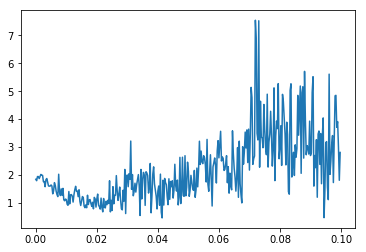

In [58]:
plt.plot(lrs, losses)
plt.show()

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [59]:
model = ResnetV2().cuda()

### 1-cycle rate training, unfreeze top hidden layers for 30 epochs

In [60]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer_group(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [61]:
batch_size = 50

In [62]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [63]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [64]:
val_metrics(model, valid_dl)

(1.9244559076097276, 0.1622222222222222)

In [65]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.422 val_loss 1.042 val_acc 0.647
train_loss 0.957 val_loss 1.016 val_acc 0.602
216 unfreezing 1
train_loss 0.912 val_loss 0.992 val_acc 0.678
train_loss 2.015 val_loss 1.442 val_acc 0.400
train_loss 1.317 val_loss 2.546 val_acc 0.311
train_loss 1.115 val_loss 4.264 val_acc 0.553
train_loss 1.169 val_loss 1.418 val_acc 0.528
train_loss 0.967 val_loss 1.193 val_acc 0.581
train_loss 0.808 val_loss 89.946 val_acc 0.422
train_loss 0.797 val_loss 1.269 val_acc 0.638
train_loss 0.705 val_loss 0.870 val_acc 0.716
train_loss 0.653 val_loss 1.085 val_acc 0.658
train_loss 0.587 val_loss 1.029 val_acc 0.672
train_loss 0.536 val_loss 0.820 val_acc 0.730
train_loss 0.501 val_loss 0.980 val_acc 0.710
train_loss 0.464 val_loss 0.959 val_acc 0.721
train_loss 0.436 val_loss 1.060 val_acc 0.707
train_loss 0.411 val_loss 1.089 val_acc 0.709
train_loss 0.380 val_loss 0.724 val_acc 0.782
/home/ubuntu/models/sandwich/ft_gw_resnet_78.pth
train_loss 0.319 val_loss 0.653 val_acc 0.802
/home/ubuntu/

0.07300818271728025

In [66]:
model = ResnetV2().cuda()

In [67]:
load_model(model, model_path/"ft_gw_resnet_83.pth")

In [68]:
val_metrics(model, valid_dl)

(0.7284822397761874, 0.8255555555555556)

# II. Resnet34 on images preprocessed with Histogram Equalization

## Train-validation split

In [69]:
path = PATH/"he-train-315"

In [70]:
files = get_files(path)

In [71]:
file_labels = [p.parts[-2] for p in files]

In [72]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

## Dataset

In [73]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [74]:
labels = [p.parts[-1] for p in paths]

In [75]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [76]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [77]:
x, y = train_ds[0]

In [78]:
batch_size = 50

In [79]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [80]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [81]:
x, y = next(iter(train_dl))

In [82]:
x = x.cuda().float()
y = y.cuda()

## Initialize pre-trained model with frozen hidden layers, train model with fixed learning rate for 10 epochs

In [87]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [88]:
model = Resnet().cuda()

In [89]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.682 val loss 0.982 val accuracy 0.636
/home/ubuntu/models/sandwich/initial_he_resnet_64.pth
train loss 0.890 val loss 0.851 val accuracy 0.717
/home/ubuntu/models/sandwich/initial_he_resnet_72.pth
train loss 0.844 val loss 0.813 val accuracy 0.734
/home/ubuntu/models/sandwich/initial_he_resnet_73.pth
train loss 0.790 val loss 0.800 val accuracy 0.731
train loss 0.786 val loss 0.892 val accuracy 0.690


## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [90]:
model = Resnet().cuda()

In [91]:
load_model(model, model_path/"initial_he_resnet_73.pth")

In [92]:
val_metrics(model, valid_dl)

(0.8128087818622589, 0.7344444444444445)

In [93]:
unfreeze(model, 7)
unfreeze(model, 6)

In [94]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/unfreeze_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [95]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.140 val loss 0.854 val accuracy 0.707
train loss 0.588 val loss 0.939 val accuracy 0.658
train loss 0.419 val loss 0.938 val accuracy 0.693
/home/ubuntu/models/sandwich/unfreeze_he_resnet_76.pth
train loss 0.307 val loss 0.888 val accuracy 0.736
train loss 0.260 val loss 0.697 val accuracy 0.796
/home/ubuntu/models/sandwich/unfreeze_he_resnet_80.pth
train loss 0.189 val loss 0.685 val accuracy 0.819
/home/ubuntu/models/sandwich/unfreeze_he_resnet_82.pth
train loss 0.155 val loss 1.026 val accuracy 0.741
train loss 0.160 val loss 0.849 val accuracy 0.789
train loss 0.123 val loss 1.079 val accuracy 0.723
train loss 0.110 val loss 0.874 val accuracy 0.796


In [66]:
model = Resnet().cuda()

In [67]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_he_resnet_82.pth")

In [68]:
val_metrics(model, valid_dl)

(0.7747624334361818, 0.8077777777777778)

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [79]:
model = ResnetV2().cuda()

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [75]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer_group(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [76]:
batch_size = 50

In [77]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [78]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [80]:
val_metrics(model, valid_dl)

(1.9079475204149883, 0.11333333333333333)

In [81]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.397 val_loss 0.988 val_acc 0.689
train_loss 1.036 val_loss 1.000 val_acc 0.631
216 unfreezing 1
train_loss 1.077 val_loss 0.897 val_acc 0.670
train_loss 2.127 val_loss 9.386 val_acc 0.196
train_loss 1.388 val_loss 1.570 val_acc 0.441
train_loss 1.110 val_loss 1.665 val_acc 0.450
train_loss 1.015 val_loss 2.196 val_acc 0.463
train_loss 0.958 val_loss 1.205 val_acc 0.596
train_loss 0.857 val_loss 1.286 val_acc 0.647
train_loss 0.770 val_loss 1.006 val_acc 0.697
train_loss 0.729 val_loss 0.977 val_acc 0.673
train_loss 0.673 val_loss 1.476 val_acc 0.612
train_loss 0.586 val_loss 0.806 val_acc 0.729
train_loss 0.559 val_loss 0.926 val_acc 0.711
train_loss 0.525 val_loss 0.732 val_acc 0.769
/home/ubuntu/models/sandwich/ft_he_resnet_77.pth
train_loss 0.503 val_loss 0.755 val_acc 0.757
train_loss 0.447 val_loss 0.729 val_acc 0.757
train_loss 0.390 val_loss 0.827 val_acc 0.731
train_loss 0.359 val_loss 0.787 val_acc 0.779
/home/ubuntu/models/sandwich/ft_he_resnet_78.pth
train_loss 

0.0605154422745626

In [82]:
model = ResnetV2().cuda()

In [83]:
load_model(model, model_path/"ft_he_resnet_82.pth")

In [84]:
val_metrics(model, valid_dl)

(0.7643823739555147, 0.8155555555555556)

# III. Resnet34 on images preprocessed with Histogram Equalization + Grey World

## Train-validation split

In [9]:
path = PATH/"hewg-train-315"

In [10]:
files = get_files(path)

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

## Dataset

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [24]:
x, y = train_ds[0]

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

## Initialize pre-trained model with frozen hidden layers, train with fixed learning rate for 10 epochs

In [61]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [62]:
model = Resnet().cuda()

In [63]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.529 val loss 0.924 val accuracy 0.676
/home/ubuntu/models/sandwich/initial_hewg_resnet_68.pth
train loss 0.882 val loss 0.848 val accuracy 0.701
/home/ubuntu/models/sandwich/initial_hewg_resnet_70.pth
train loss 0.927 val loss 0.855 val accuracy 0.710
/home/ubuntu/models/sandwich/initial_hewg_resnet_71.pth
train loss 0.803 val loss 0.851 val accuracy 0.700
train loss 0.838 val loss 0.967 val accuracy 0.686


## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [81]:
model = Resnet().cuda()

In [82]:
load_model(model, model_path/"initial_hewg_resnet_71.pth")

In [83]:
val_metrics(model, valid_dl)

(0.8553838498062558, 0.71)

In [86]:
unfreeze(model, 7)
unfreeze(model, 6)

In [87]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.71:
                path = "{0}/unfreeze_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [88]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.216 val loss 0.944 val accuracy 0.671
train loss 0.562 val loss 0.796 val accuracy 0.732
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_73.pth
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_75.pth
train loss 0.385 val loss 0.665 val accuracy 0.780
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_78.pth
train loss 0.308 val loss 0.832 val accuracy 0.749
train loss 0.240 val loss 0.844 val accuracy 0.773
train loss 0.204 val loss 0.836 val accuracy 0.761
train loss 0.139 val loss 0.943 val accuracy 0.768
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_79.pth
train loss 0.125 val loss 0.858 val accuracy 0.772
train loss 0.111 val loss 0.883 val accuracy 0.778
train loss 0.083 val loss 0.861 val accuracy 0.777
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_82.pth


In [89]:
model = Resnet().cuda()

In [90]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_82.pth")

In [91]:
val_metrics(model, valid_dl)

(0.7238615949948629, 0.8211111111111111)

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [99]:
model = ResnetV2().cuda()

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [95]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer_group(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.71:
                path = "{0}/ft_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [96]:
batch_size = 50

In [97]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [98]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [100]:
val_metrics(model, valid_dl)

(1.875699394279056, 0.17222222222222222)

In [101]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.430 val_loss 1.065 val_acc 0.650
train_loss 1.034 val_loss 0.911 val_acc 0.681
216 unfreezing 1
train_loss 1.037 val_loss 1.255 val_acc 0.571
train_loss 1.843 val_loss 1.433 val_acc 0.500
train_loss 1.302 val_loss 1.505 val_acc 0.457
train_loss 1.252 val_loss 224.853 val_acc 0.220
train_loss 1.065 val_loss 2.609 val_acc 0.351
train_loss 0.897 val_loss 1.179 val_acc 0.589
train_loss 0.819 val_loss 1.554 val_acc 0.622
train_loss 0.766 val_loss 0.850 val_acc 0.726
/home/ubuntu/models/sandwich/ft_hewg_resnet_73.pth
train_loss 0.741 val_loss 1.121 val_acc 0.640
train_loss 0.710 val_loss 0.771 val_acc 0.746
/home/ubuntu/models/sandwich/ft_hewg_resnet_75.pth
train_loss 0.663 val_loss 1.112 val_acc 0.650
train_loss 0.593 val_loss 0.764 val_acc 0.752
/home/ubuntu/models/sandwich/ft_hewg_resnet_75.pth
train_loss 0.534 val_loss 0.713 val_acc 0.773
/home/ubuntu/models/sandwich/ft_hewg_resnet_77.pth
train_loss 0.489 val_loss 0.770 val_acc 0.777
/home/ubuntu/models/sandwich/ft_hewg_resn

0.07116714126378712

In [102]:
model = ResnetV2().cuda()

In [103]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/ft_hewg_resnet_82.pth")

In [104]:
val_metrics(model, valid_dl)

(0.7655745827489429, 0.8222222222222222)

# IV. Resnet34 with Grey World + Histogram Equalization as a random data augmentation

## Data augmentation

In [2]:
import colorcorrect.algorithm as cca

In [7]:
def gwhe_img(img):
    img = cca.grey_world(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    y_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
    img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)
    return cv2.cvtColor(img_rgb_eq, cv2.COLOR_RGB2BGR)

## Train-validation split

In [10]:
path = PATH/"train-315"

In [11]:
files = get_files(path)

In [13]:
file_labels = [p.parts[-2] for p in files]

In [14]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

## Dataset

In [18]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [19]:
labels = [p.parts[-1] for p in paths]

In [21]:
class SandwichDatasetGWHE(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]] 
        x = cv2.imread(str(path)).astype(np.float32)
        if self.transforms:
            # Randomly apply Grey World and Histogram Equalization to image
            if np.random.random() > 0.5: x = gwhe_img(x).copy()
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [22]:
train_ds = SandwichDatasetGWHE(files=train_files, labels=labels, transforms=True)

In [24]:
valid_ds = SandwichDatasetGWHE(files=valid_files, labels=labels, transforms=False)

In [27]:
x, y = train_ds[0]

In [29]:
batch_size = 50

In [30]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [31]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [32]:
x, y = next(iter(train_dl))

In [33]:
x = x.cuda().float()
y = y.cuda()

## Initialize pre-trained model with frozen hidden layers, train with fixed learning rate for 10 epochs

In [62]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [63]:
model = Resnet().cuda()

In [64]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.554 val loss 0.914 val accuracy 0.670
/home/ubuntu/models/sandwich/initial_aug_resnet_67.pth
/home/ubuntu/models/sandwich/initial_aug_resnet_69.pth
train loss 0.942 val loss 0.853 val accuracy 0.698
/home/ubuntu/models/sandwich/initial_aug_resnet_70.pth
train loss 0.887 val loss 1.004 val accuracy 0.649
/home/ubuntu/models/sandwich/initial_aug_resnet_73.pth
train loss 0.814 val loss 0.720 val accuracy 0.754
/home/ubuntu/models/sandwich/initial_aug_resnet_75.pth
train loss 0.808 val loss 0.847 val accuracy 0.739


## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [66]:
model = Resnet().cuda()

In [67]:
load_model(model, model_path/"initial_aug_resnet_75.pth")

In [68]:
val_metrics(model, valid_dl)

(0.7203980055120256, 0.7544444444444445)

In [71]:
unfreeze(model, 7)
unfreeze(model, 6)

In [72]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "{0}/unfreeze_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [73]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.147 val loss 0.806 val accuracy 0.738
train loss 0.583 val loss 0.887 val accuracy 0.706
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_76.pth
train loss 0.426 val loss 0.750 val accuracy 0.763
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_77.pth
train loss 0.333 val loss 0.777 val accuracy 0.773
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_79.pth
train loss 0.240 val loss 1.349 val accuracy 0.688
train loss 0.213 val loss 0.700 val accuracy 0.801
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_80.pth
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_82.pth
train loss 0.173 val loss 0.758 val accuracy 0.790
train loss 0.146 val loss 0.823 val accuracy 0.799
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_83.pth
train loss 0.102 val loss 0.874 val accuracy 0.809
train loss 0.149 val loss 0.834 val accuracy 0.799
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_84.pth


In [74]:
model = Resnet().cuda()

In [75]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_aug_resnet_84.pth")

In [76]:
val_metrics(model, valid_dl)

(0.609929227994548, 0.8377777777777777)

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [87]:
model = ResnetV2().cuda()

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [86]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer_group(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [88]:
val_metrics(model, valid_dl)

(1.9267942772971258, 0.14333333333333334)

In [89]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.381 val_loss 0.952 val_acc 0.688
train_loss 0.961 val_loss 0.945 val_acc 0.629
216 unfreezing 1
train_loss 0.981 val_loss 0.865 val_acc 0.689
train_loss 2.271 val_loss 2.265 val_acc 0.287
train_loss 1.390 val_loss 1.379 val_acc 0.510
train_loss 1.419 val_loss 19.780 val_acc 0.309
train_loss 1.239 val_loss 1.508 val_acc 0.492
train_loss 0.990 val_loss 1.410 val_acc 0.534
train_loss 0.911 val_loss 0.986 val_acc 0.709
train_loss 0.843 val_loss 1.233 val_acc 0.563
train_loss 0.789 val_loss 0.734 val_acc 0.744
/home/ubuntu/models/sandwich/ft_aug_resnet_74.pth
train_loss 0.735 val_loss 0.984 val_acc 0.674
train_loss 0.661 val_loss 1.081 val_acc 0.674
train_loss 0.612 val_loss 0.810 val_acc 0.728
train_loss 0.585 val_loss 0.690 val_acc 0.789
/home/ubuntu/models/sandwich/ft_aug_resnet_79.pth
train_loss 0.567 val_loss 0.890 val_acc 0.718
train_loss 0.565 val_loss 0.944 val_acc 0.713
train_loss 0.466 val_loss 0.848 val_acc 0.761
train_loss 0.455 val_loss 0.686 val_acc 0.779
train_lo

0.12141090502134627

In [90]:
model = ResnetV2().cuda()

In [91]:
load_model(model, model_path/"ft_aug_resnet_84.pth")

In [92]:
val_metrics(model, valid_dl)

(0.6474739015102386, 0.8355555555555556)